# RFID Radio Propagation Analytics
This notebook is aimed to demostrate physical computation that is used for Bit Error Probability (BER) evaluation.

In [5]:
%matplotlib notebook
%pylab
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from pyrfidphy import channel as ch
# import pyradise as prs

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


### Parameters initialization
Here are the parameters of the model, which are as follows:
 * radio media (environment) parameters;
 * parameters of reader antenna system;
 * parameters of tag antenna system.

In [6]:
# environment parameters
speed_of_light = 2.99792458 * 10e8
frequency = 860*10e6
wave_length = speed_of_light / frequency
thermal_noise = -116 #dBm
permittivity = 15
conductivity = 0.03

# reader paramters
reader_height = 5.0 #m
reader_angle  = pi/4
reader_tx_power = 31.5 #dBm
reader_antenna_gain = 6 #dBi
reader_noise  = -80 #dBm
reader_cabel_loss = -2 

# tag parameters
tag_speed = 20 #mps
tag_height = 0.5 #m
tag_angle  = pi/2
tag_antenna_gain = 2 #dBi 
tag_modulation_loss = -12.0 #dB
# tag_sensitivity=-17.5 #dBm
tag_sensitivity=-25 #dBm

# mutual parameters
polarization_loss = -3.0 #dB
ceil_height = 6

Define an utility function performing creation of 2D-space-time array.  

In [8]:

def make_space_time_greed_(distance, time, function, **kwargs):
    return np.array([[function(distance=d, time=t, **kwargs) for d in distance] for t in time])

### Wrappers for functions computing antenna radiation pattern (RP) and reflection coefficients.

Radiation pattern for a patch antenna $L \times W$:

$$ \Gamma(\theta, \phi) = \left| 
	\frac{\sin{kW\sin{\theta}\sin{\phi}}}{kW\sin{\theta}\sin{\phi}}
		\cos{kL\sin{\theta}\cos{\phi}} \right| \times
		\sqrt{\cos^2{\phi} + \cos^2{\theta}\sin^2{\phi}}, $$

where $\theta$ is an elevating angle, and a reader antenna, $\phi$ is an azimuth angle, $k$ is a wave number.

Reflection coefficient is given by the following formula:

$$ R = \frac{\sin\phi - \sqrt{C}}{\sin\phi + \sqrt{C}} $$

where $\phi$ is a grazing angle, $C$ defined by the following expression:

$$ C = \eta - \cos^2\phi \text{ for horizontal polarization,} $$
$$ C = \frac{\eta - \cos^2\phi}{\eta^2} \text{for vertical one.} $$ 

$$\eta = \epsilon_r(f)-j60\lambda\sigma(f), $$

where $\epsilon_r(f)$ is a relative permittivity of a ground surface at the frequency $f$, $\sigma(f)$ is a conductivity.

In [7]:
def patch_rp_(theta, phi):
    return ch.patch_rp(azimuth=theta, tilt=phi, wavelen=wave_length, width=wave_length/2, length=wave_length/2)

def reflection_paral_(phi):
    return ch.reflection(grazing_angle=phi, polarization=1., permittivity=permittivity, 
                          conductivity=conductivity, wavelen=wave_length)

def reflection_perp_(phi):
    return ch.reflection(grazing_angle=phi, polarization=0., permittivity=permittivity, 
                          conductivity=conductivity, wavelen=wave_length)

def reflection_circ_(phi):
    return ch.reflection(grazing_angle=phi, polarization=.5, permittivity=permittivity, 
                          conductivity=conductivity, wavelen=wave_length)

### Path loss and Link budget computation

Path loss is computated in assuption of multi-ray propagation media, presence of movement leading to Doppler's effect consideration, antennas radiation patterns and cmoplex reflection coefficient. The formula obtained are as follows:

$$
A_{pl} = \left(\frac{\lambda}{4\pi}\right)^2
	\left|\sum\limits_{i=0}^{N} \frac{R_i\Gamma_i}{d_i} 
		e^{-jk(d_i-\upsilon t \cos{\psi_i})}\right|^2, $$

where $c$ is a speed of light, $\upsilon$ is a relative speed of a receiver, $\psi_i$ is an angle between the wave vector $\vec{k_i}$ of $i$-th ray and the direction of movement, $\lambda$ is a wave length, $d_i$ is a length of $i$-th path, $R_i$ is a reflection coefficient of $i$-th ray (for line-of-sight ray we assumed $R_0 = 1$) and $\Gamma_i = \Gamma_i^{(r)}\Gamma_i^{(t)}$ is a coefficient correspond to a reader and a tag antenna radiation patterns properly.

For the presence computation a  number of rays $N$ equals to 1, thus the formula modulate two-ray propagation wih one reflected component, non line-of-site (NLoS) and LoS component.


The power received from the reader at the tag side is:

$$ P_r^{(t)} = P_t^{(r)} G^{(r)} A_{pl}^{(d)} A_{pol} G^{(t)}, $$

where $P_t^{(r)}$ is a reader transmission power, $G^{(r)}$ is an antenna gain, $A_{pl}^{(d)}$ is a path loss attenuation, $A_{pol}$ is a polarization loss, $G^{(t)}$ is a tag antenna has gain. If this power is lower the tag sensitivity $P_s^{(t)}$ the tag does not power up and will not able to communicate with the reader. Otherwise the tag modulate a backscattering signal $P_t^{(t)}$. The signal received at the reader side is:

$$ P_r^{(r)} = P_r^{(t)} G^{(t)} A_{bs} A_{pl}^{(r)} A_{pol} G^{(r)}, $$

where $A_{bs}$ is a backscattering loss caused by modulation loss, impedance mismatch, etc.

In [9]:
tx_position_3d        = np.array([0,0,reader_height])
tx_direction_theta_3d = np.array([np.sin(reader_angle), 0, -np.cos(reader_angle)])
tx_direction_phi_3d   = np.array([0,1,0])
tx_velocity_3d        = np.array([0,0,0])

rx_direction_theta_3d = np.array([-1,0,0])
rx_direction_phi_3d   = np.array([0,-1,0])

def two_ray_3d_(distance, time, speed, polarization):
    return ch.two_ray_path_loss_3d(time=time, ground_reflection=ch.reflection, 
            polarization=polarization, permittivity=permittivity, conductivity=conductivity,
            tx_pos=tx_position_3d, tx_dir_theta=tx_direction_theta_3d, tx_dir_phi=tx_direction_phi_3d, 
                                    tx_velocity=tx_velocity_3d, tx_rp=ch.patch_rp,
#                                     tx_velocity=tx_velocity_3d, tx_rp=ch.dipole_rp,
            rx_pos=np.array([distance,0,tag_height]), rx_dir_theta=rx_direction_theta_3d, rx_dir_phi=rx_direction_phi_3d, 
                                    rx_velocity=np.array([-speed,0,0]), rx_rp=ch.dipole_rp, 
            wavelen=wave_length, width=wave_length/2, length=wave_length/2)

# def two_ray_3d_inverse_(distance, time, speed, polarization):
#     return ch.two_ray_path_loss_3d(time=time, ground_reflection=ch.reflection, 
#             polarization=polarization, permittivity=permittivity, conductivity=conductivity,
#             tx_pos=np.array([distance,0,tag_height]), tx_dir_theta=rx_direction_theta_3d, tx_dir_phi=rx_direction_phi_3d, 
# #             tx_velocity=tx_velocity_3d, tx_rp=ch.patch_rp,
#                                     tx_velocity=np.array([speed,0,0]), tx_rp=ch.dipole_rp,
#             rx_pos=tx_position_3d, rx_dir_theta=tx_direction_theta_3d, rx_dir_phi=tx_direction_phi_3d, 
#                                     rx_velocity=tx_velocity_3d, rx_rp=ch.dipole_rp, 
#             wavelen=wave_length, width=wave_length/2, length=wave_length/2)

def rx_power_tag_(pathloss):
    return (reader_tx_power + reader_antenna_gain + reader_cabel_loss + 
            pathloss + tag_antenna_gain + polarization_loss)

def tx_power_tag_(rx_power_tag):
    return rx_power_tag + tag_modulation_loss if rx_power_tag >= tag_sensitivity else thermal_noise

def rx_power_reader_(pathloss, tx_power_tag):    
    return (tx_power_tag + tag_antenna_gain + pathloss + polarization_loss +
                reader_cabel_loss + reader_antenna_gain) if tx_power_tag >= reader_noise else thermal_noise


def rx_power_tag_complete_3d_(distance, time, speed):
    pathloss_fwd = ch.lin2db(two_ray_3d_(distance, time, speed, 0.5))  # computing path loss from reader to tag 
    return rx_power_tag_(pathloss_fwd)


def tx_power_tag_complete_3d_(distance, time, speed):
    rx_power_tag = rx_power_tag_complete_3d_(distance, time, speed)
    return rx_power_tag + tag_modulation_loss if rx_power_tag >= tag_sensitivity else thermal_noise


def rx_power_reader_complete_3d_(distance, time, speed):
    pathloss_fwd = ch.lin2db(two_ray_3d_(distance, time, speed, .5))  # computing path loss from reader to tag 
    rx_power_tag = rx_power_tag_(pathloss_fwd)                      # computing RX power at tag
    tx_power_tag = tx_power_tag_(rx_power_tag)                      # computing TX power of tag
    pathloss_bwd = ch.lin2db(two_ray_3d_(distance, time, speed, 1.))  # computing path loss from tag to reader
    return rx_power_reader_(pathloss_bwd, tx_power_tag)


def snr_3d_(distance, time, speed):
    rx_power = rx_power_reader_complete_3d_(distance, time, speed)
    return ch.signal2noise(rx_power=rx_power, noise_power=reader_noise)


def ber_over_awgn_3d_(distance, time, speed):
    snr = snr_3d_(distance, time, speed)
    sync_angle = ch.sync_angle(snr=snr, preamble_duration=825e-6)
    snr_extended = ch.snr_extended(snr=snr, sync_phi=sync_angle, symbol_duration=9.375e-6, miller=4)
    return ch.ber_over_awgn(snr=snr_extended)


def ber_over_rayleigh_3d_(distance, time, speed):
    snr = snr_3d_(distance, time, speed)
    sync_angle = ch.sync_angle(snr=snr, preamble_duration=825e-6)
    snr_extended = ch.snr_extended(snr=snr, sync_phi=sync_angle, symbol_duration=4.6875e-6, miller=4)
    return ch.ber_over_rayleigh(snr=snr_extended)

Here are computation of the antenna gain obtained from the specific radiation pattern given.

In [10]:
#
# Antenna gain computation
#
def antenna_gain_(radiation_pattern, theta, **kwargs):
    max_gain  = radiation_pattern(azimuth=0, **kwargs)
    mean_gain = np.sum([radiation_pattern(azimuth=t, **kwargs) for t in theta]) / theta.size
    return ch.lin2db(max_gain / mean_gain)

def antenna_gain_2d_(radiation_pattern, theta, tilt, **kwargs):
    max_gain  = radiation_pattern(0, tilt, **kwargs)
    mean_gain = np.sum([radiation_pattern(t, tilt, **kwargs) for t in theta]) / theta.size
    return ch.lin2db(max_gain / mean_gain)

theta = np.linspace(-pi, pi, num=100)

gain_iso = antenna_gain_(ch.isotropic_rp, theta)
gain_dip = antenna_gain_(ch.dipole_rp, theta)
gain_arr = antenna_gain_(ch.array_dipole_rp, theta, n=2)
gain_hel = antenna_gain_(ch.helix_rp, theta, n=3)

print(gain_iso, gain_dip, gain_arr, gain_hel)

gain_patch_0 = antenna_gain_2d_(patch_rp_, theta, 0.0)
gain_patch_1 = antenna_gain_2d_(patch_rp_, theta, pi/6)
gain_patch_2 = antenna_gain_2d_(patch_rp_, theta, pi/4)
gain_patch_3 = antenna_gain_2d_(patch_rp_, theta, pi/3)
gain_patch_4 = antenna_gain_2d_(patch_rp_, theta, pi/12*5)

print(gain_patch_0, gain_patch_1, gain_patch_2, gain_patch_3, gain_patch_4)

0.0 5.349029975306875 6.314535216429676 5.392705253793354
6.314535216429675 5.67962938579154 5.334393666807177 5.252871482124313 5.417786106090564


### Further different computation examples are presented

Examples of reflection coefficient computation versus different angles.

<IPython.core.display.Javascript object>


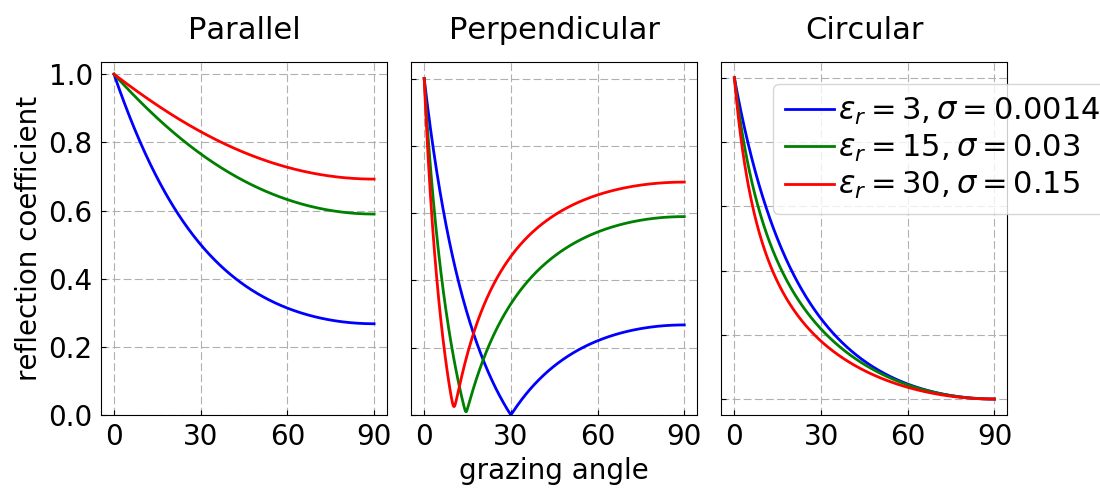

In [11]:
phi = np.linspace(0.0, pi/2, num=500)

r_pl_0 = [np.absolute(ch.reflection(grazing_angle=t, polarization=1., permittivity=3, conductivity=0.0014, 
                                   wavelen=wave_length))for t in phi]
r_pp_0 = [np.absolute(ch.reflection(grazing_angle=t, polarization=0., permittivity=3, conductivity=0.0014, 
                                   wavelen=wave_length))for t in phi]
r_c_0  = [np.absolute(ch.reflection(grazing_angle=t, polarization=.5, permittivity=3, conductivity=0.0014, 
                                   wavelen=wave_length))for t in phi]

r_pl_1 = [np.absolute(ch.reflection(grazing_angle=t, polarization=1., permittivity=15, conductivity=0.03, 
                                   wavelen=wave_length))for t in phi]
r_pp_1 = [np.absolute(ch.reflection(grazing_angle=t, polarization=0., permittivity=15, conductivity=0.03, 
                                   wavelen=wave_length))for t in phi]
r_c_1  = [np.absolute(ch.reflection(grazing_angle=t, polarization=.5, permittivity=15, conductivity=0.03, 
                                   wavelen=wave_length))for t in phi]

r_pl_2 = [np.absolute(ch.reflection(grazing_angle=t, polarization=1., permittivity=30, conductivity=0.15, 
                                   wavelen=wave_length))for t in phi]
r_pp_2 = [np.absolute(ch.reflection(grazing_angle=t, polarization=0., permittivity=30, conductivity=0.15, 
                                   wavelen=wave_length))for t in phi]
r_c_2  = [np.absolute(ch.reflection(grazing_angle=t, polarization=.5, permittivity=30, conductivity=0.15, 
                                   wavelen=wave_length))for t in phi]

fig = figure(1, figsize=(11,5))
plt.rc('font', family='sans-serif')

ax1 = subplot2grid((1,13), (0,0), colspan=4)
ax2 = subplot2grid((1,13), (0,4), colspan=4)
ax3 = subplot2grid((1,13), (0,8), colspan=4)
# ax4 = subplot2grid((1,4), (0,3))


label_str = "$\epsilon_{{r}}={0}, \sigma={1}$"

ax1.plot(phi*180/pi, r_pl_0, color='blue', linewidth=2)
ax2.plot(phi*180/pi, r_pp_0, color='blue', linewidth=2)
ax3.plot(phi*180/pi, r_c_0,  color='blue', linewidth=2, label=label_str.format(3, 0.0014))

ax1.plot(phi*180/pi, r_pl_1, color='green', linewidth=2)
ax2.plot(phi*180/pi, r_pp_1, color='green', linewidth=2)
ax3.plot(phi*180/pi, r_c_1,  color='green', linewidth=2, label=label_str.format(15, 0.03))

ax1.plot(phi*180/pi, r_pl_2, color='red', linewidth=2)
ax2.plot(phi*180/pi, r_pp_2, color='red', linewidth=2)
ax3.plot(phi*180/pi, r_c_2,  color='red', linewidth=2, label=label_str.format(30, 0.15))

ax1.set_xticks(arange(4)*30)
ax2.set_xticks(arange(4)*30)
ax3.set_xticks(arange(4)*30)
ax1.set_yticks(arange(6)/5.)
ax2.set_yticks(arange(6)/5.)
ax3.set_yticks(arange(6)/5.)
ax1.set_ybound(lower=0)
ax2.set_ybound(lower=0)
ax2.set_ybound(lower=0)
ax1.tick_params(labelsize=20, direction='in', pad=6)
ax2.tick_params(labelsize=20, direction='in', pad=6)
ax3.tick_params(labelsize=20, direction='in', pad=6)

ax2.set_yticklabels(['' for i in arange(6)])
ax3.set_yticklabels(['' for i in arange(6)])

ax1.set_title('Parallel', fontdict={'fontsize': 22}, y=1.04)
ax2.set_title('Perpendicular', fontdict={'fontsize': 22}, y=1.04)
ax3.set_title('Circular', fontdict={'fontsize': 22}, y=1.04)

ax1.grid(linestyle='--', linewidth=0.8)
ax2.grid(linestyle='--', linewidth=0.8)
ax3.grid(linestyle='--', linewidth=0.8)

ax1.set_ylabel('reflection coefficient', fontdict={'fontsize': 20})
ax2.set_xlabel('grazing angle', fontdict={'fontsize': 20})

plt.subplots_adjust(wspace=1.8, hspace=0.0)
plt.show()
fig.tight_layout()
legend(fontsize=22, handlelength=1.6, handletextpad=0.14, labelspacing=0.2, loc=(0.18, 0.57))
savefig('reflection.eps')

Example of path loss computation.

<IPython.core.display.Javascript object>


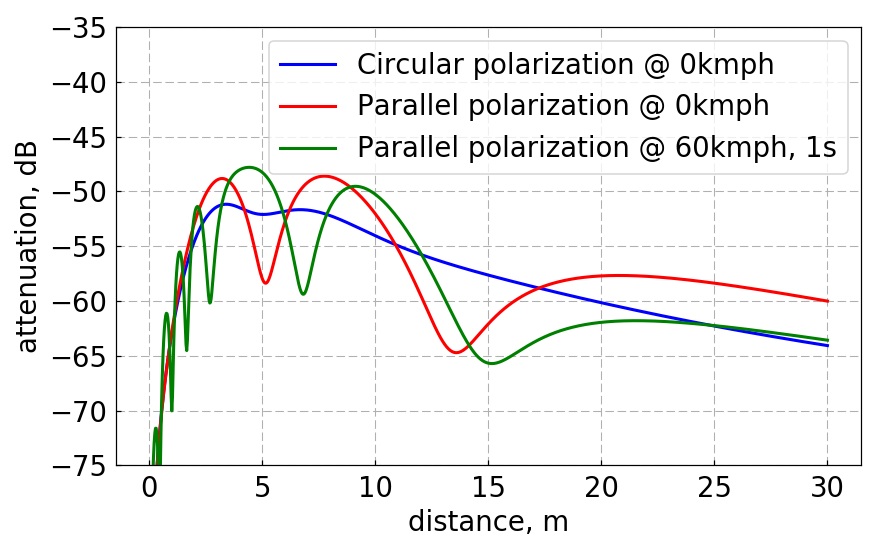

In [22]:
dist = linspace(0., 30, 1000)

pathloss_c0 = [ch.lin2db(two_ray_3d_(d, 0.0, 0, 0.5)) for d in dist]
pathloss_p0 = [ch.lin2db(two_ray_3d_(d, 0.0, 0, 1)) for d in dist]
pathloss_p2 = [ch.lin2db(two_ray_3d_(d, 1., 60/3.6, 1)) for d in dist]

fig = figure(2, figsize=(8,5))
plt.rc('font', family='sans-serif')
ax = subplot(111)

plot(dist, pathloss_c0, 'b', linewidth=2, label='Circular polarization @ 0kmph')
plot(dist, pathloss_p0, 'r', linewidth=2, label='Parallel polarization @ 0kmph')
plot(dist, pathloss_p2, 'g', linewidth=2, label='Parallel polarization @ 60kmph, 1s')

grid(linestyle='--', linewidth=0.7)
ax.set_yticks(arange(-75, -30, 5))
ax.set_ybound(lower=-75)
ax.tick_params(labelsize=18, direction='in', pad=6)

ax.set_ylabel('attenuation, dB', fontdict={'fontsize': 18})
ax.set_xlabel('distance, m', fontdict={'fontsize': 18})

legend(fontsize=18)

fig.tight_layout()
savefig('pathloss_cases.eps')

Example of BER computation.

<IPython.core.display.Javascript object>


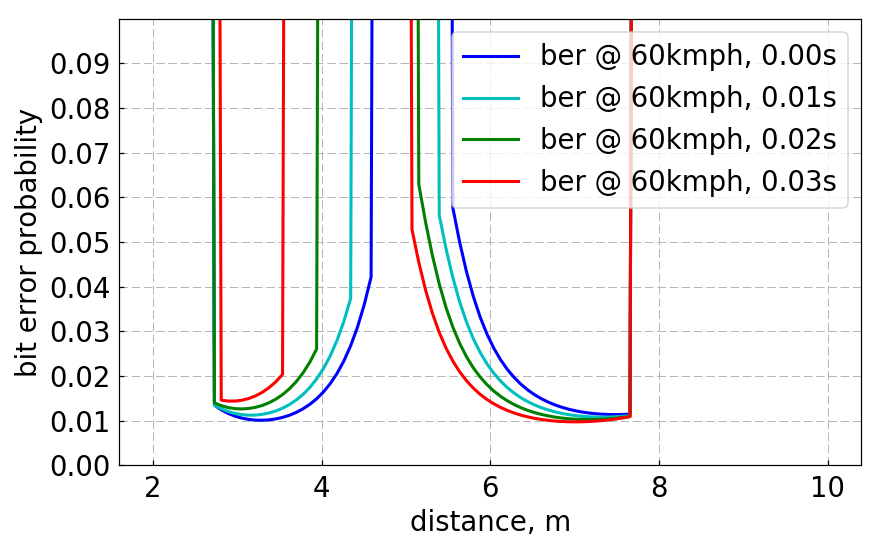

In [24]:
dist  = linspace(2, 10, 100)
ber_0 = [ber_over_rayleigh_3d_(d, 0.00, 60/3.6) for d in dist]
ber_1 = [ber_over_rayleigh_3d_(d, 0.01, 60/3.6) for d in dist]
ber_2 = [ber_over_rayleigh_3d_(d, 0.02, 60/3.6) for d in dist]
ber_3 = [ber_over_rayleigh_3d_(d, 0.03, 60/3.6) for d in dist]

fig = figure(3, figsize(8, 5))
ax = subplot(111)
plt.rc('font', family='sans-serif')

plot(dist, ber_0, 'b', label='ber @ 60kmph, 0.00s', linewidth=2)
plot(dist, ber_1, 'c', label='ber @ 60kmph, 0.01s', linewidth=2)
plot(dist, ber_2, 'g', label='ber @ 60kmph, 0.02s', linewidth=2)
plot(dist, ber_3, 'r', label='ber @ 60kmph, 0.03s', linewidth=2)

ax.set_yticks(arange(0.0, 0.1, 0.01))
ax.set_ybound(lower=0, upper=0.1)
ax.tick_params(labelsize=18, direction='in', pad=6)

ax.set_ylabel('bit error probability', fontdict={'fontsize': 18})
ax.set_xlabel('distance, m', fontdict={'fontsize': 18})

grid(linestyle='--', linewidth=0.6)
legend(fontsize=18)
fig.tight_layout()

savefig('ber_cases.eps')

Pathloss and link bugdet parameters.

<IPython.core.display.Javascript object>


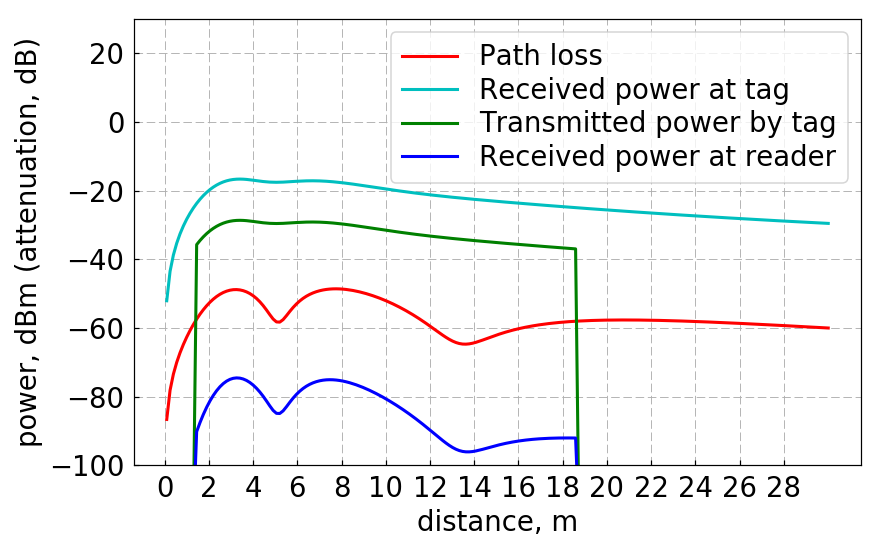

In [13]:
dist = linspace(0.1, 30, 200)

# pathloss_f = [ch.lin2db(two_ray_3d_(d, 0.0, 0, 0.5))     for d in dist]
pathloss_b = [ch.lin2db(two_ray_3d_(d, 0.0, 0, 1))        for d in dist]
rx_reader  = [rx_power_reader_complete_3d_(d, .0, 60/3.6) for d in dist]
rx_tag     = [rx_power_tag_complete_3d_(d, .0, 60/3.6)    for d in dist]
tx_tag     = [tx_power_tag_complete_3d_(d, .0, 60/3.6)    for d in dist]

fig = figure(4, figsize(8, 5))
ax = subplot(111)
plt.rc('font', family='sans-serif')

# plot(dist, pathloss_f, label='Pathloss from reader to tag', linewidth=2)
plot(dist, pathloss_b, 'r', label='Path loss',                linewidth=2)
plot(dist, rx_tag,     'c', label='Received power at tag',    linewidth=2)
plot(dist, tx_tag,     'g', label='Transmitted power by tag', linewidth=2)
plot(dist, rx_reader,  'b', label='Received power at reader', linewidth=2)


# ax.set_yticks(arange(0.0, 0.1, 0.01))
ax.set_xticks(arange(0.0, 30, 2))
ax.set_ybound(lower=-100, upper=30)
ax.tick_params(labelsize=18, direction='in', pad=6)

ax.set_ylabel('power, dBm (attenuation, dB)', fontdict={'fontsize': 18})
ax.set_xlabel('distance, m', fontdict={'fontsize': 18})

grid(linestyle='--', linewidth=.6)

legend(fontsize=18, labelspacing=0.2)
fig.tight_layout()

savefig('link_budget.eps')

Computation on the grid for computation of parameters that ate as follows:
* power incident to tag;
* power incident to reader;
* path loss;
* BER over AWGN channel;
* BER over Rayleigh channel.

Next plots depicting the results are presented

In [14]:
distance = np.linspace(1, 10., 100)
time     = np.linspace(0, 2, 100)

pathloss_greed = ch.lin2db(make_space_time_greed_(distance, time, two_ray_3d_, speed=tag_speed, polarization=1))
rx_tag_greed       = make_space_time_greed_(distance, time, rx_power_tag_complete_3d_, speed=tag_speed)
rx_reader_greed    = make_space_time_greed_(distance, time, rx_power_reader_complete_3d_, speed=tag_speed)
ber_awgn_greed     = make_space_time_greed_(distance, time, ber_over_awgn_3d_, speed=tag_speed)
ber_rayleigh_greed = make_space_time_greed_(distance, time, ber_over_rayleigh_3d_, speed=tag_speed)

<IPython.core.display.Javascript object>


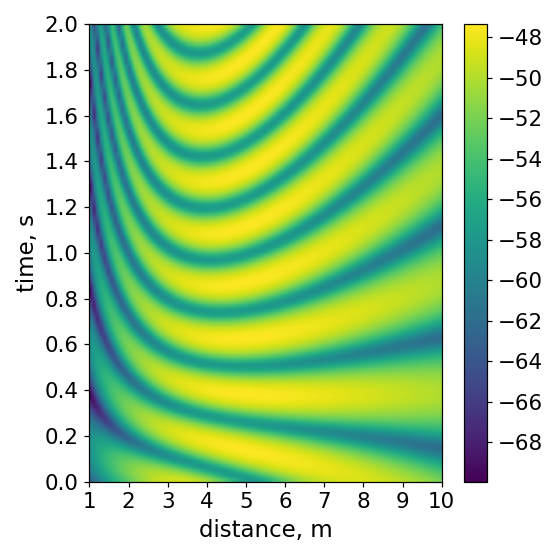

In [15]:
fig = plt.figure(5, figsize=(5.08, 5.08)) # 2 inches

D,T = meshgrid(distance, time)
P = pathloss_greed

im = plt.imshow(P, aspect='auto', interpolation='gaussian',
                origin='lower', extent=[1, 10, 0, 2])

cbar = plt.colorbar(ticks=-2*np.arange(np.floor(P.max()-P.min())/2) + np.floor(P.max()))
cbar.ax.tick_params(labelsize=14)

im.axes.set_xticks(np.arange(10) + 1)
im.axes.set_yticks(0.2*np.arange(11))
im.axes.set_xlabel('distance, m', fontdict={'fontsize': 15})
im.axes.set_ylabel('time, s', fontdict={'fontsize': 15})
plt.tick_params(labelsize=14)

# plt.title('Bit Error Probability', fontdict={'fontsize': 16})
fig.tight_layout()
savefig('pathloss.eps', dpi = 250, facecolor='w', edgecolor='w')

<IPython.core.display.Javascript object>


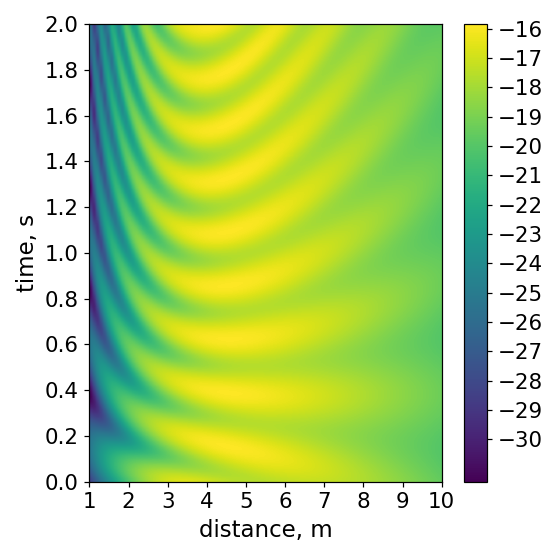

In [16]:
fig = plt.figure(6, figsize=(5.08, 5.08)) # 2 inches

D,T = meshgrid(distance, time)
P = rx_tag_greed

im = plt.imshow(P, aspect='auto', interpolation='gaussian',
                origin='lower', extent=[1, 10, 0, 2])

cbar = plt.colorbar(ticks=-np.arange(np.floor(P.max()-P.min())) + np.floor(P.max()))
cbar.ax.tick_params(labelsize=14)

im.axes.set_xticks(np.arange(10) + 1)
im.axes.set_yticks(0.2*np.arange(11))
im.axes.set_xlabel('distance, m', fontdict={'fontsize': 15})
im.axes.set_ylabel('time, s', fontdict={'fontsize': 15})
plt.tick_params(labelsize=14)

# plt.title('Bit Error Probability', fontdict={'fontsize': 16})
fig.tight_layout()
savefig('rx_tag.eps', dpi = 250, facecolor='w', edgecolor='w')


<IPython.core.display.Javascript object>


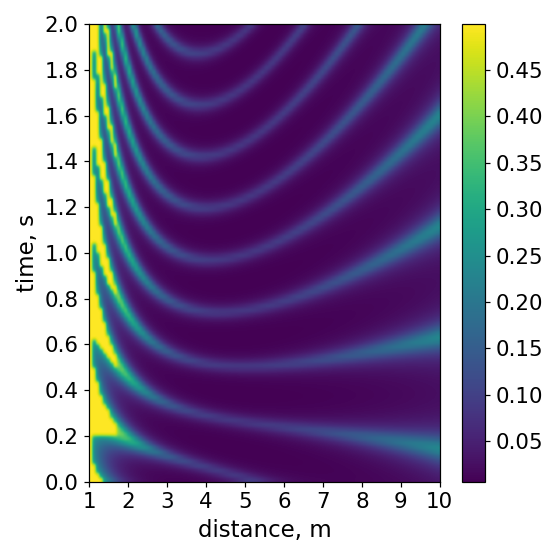

In [17]:
fig = plt.figure(7, figsize=(5.08, 5.08)) # 2 inches

D,T = meshgrid(distance, time)
P = ber_rayleigh_greed


im = plt.imshow(P, aspect='auto', interpolation='gaussian',
                origin='lower', extent=[1, 10, 0, 2])

cbar = plt.colorbar(ticks=-0.05*np.arange(12) + 0.5)
cbar.ax.tick_params(labelsize=14)

im.axes.set_xticks(np.arange(10) + 1)
im.axes.set_yticks(0.2*np.arange(11))
im.axes.set_xlabel('distance, m', fontdict={'fontsize': 15})
im.axes.set_ylabel('time, s', fontdict={'fontsize': 15})
plt.tick_params(labelsize=14)

# plt.title('Bit Error Probability', fontdict={'fontsize': 16})
fig.tight_layout()
savefig('ber.eps', dpi = 250, facecolor='w', edgecolor='w')

# min_ber = 0.5
# cum = 0
# count = 0
# for ber_a in ber_rayleigh_greed:
#     for ber in ber_a:
#         if min_ber > ber:
#             min_ber = ber
#         if ber < 0.02:
#             cum += ber
#             count += 1

# min_ber, count/300/300, cum/count 

<IPython.core.display.Javascript object>


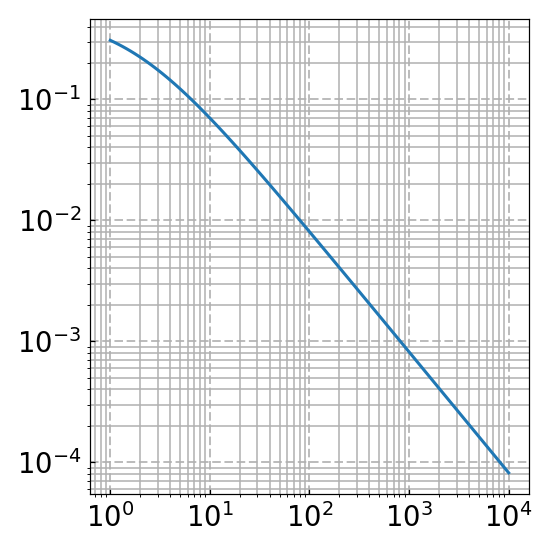

In [34]:
snr = [ch.db2lin(dbm) for dbm in linspace(0, 40, 100)]

ber = [ch.ber_over_rayleigh(snr=snr_i) for snr_i in snr]

fig = figure(8, figsize(5, 5))
ax = subplot(111)
# plt.rc('font', family='sans-serif')

loglog(snr, ber, linewidth=2)

ax.tick_params(labelsize=18, direction='in', pad=6)

grid(linewidth=1., which='minor')
grid(linewidth=1.1, linestyle='--', which='major')

# legend(fontsize=18)
fig.tight_layout()

# savefig('ber-plot.eps')

<IPython.core.display.Javascript object>


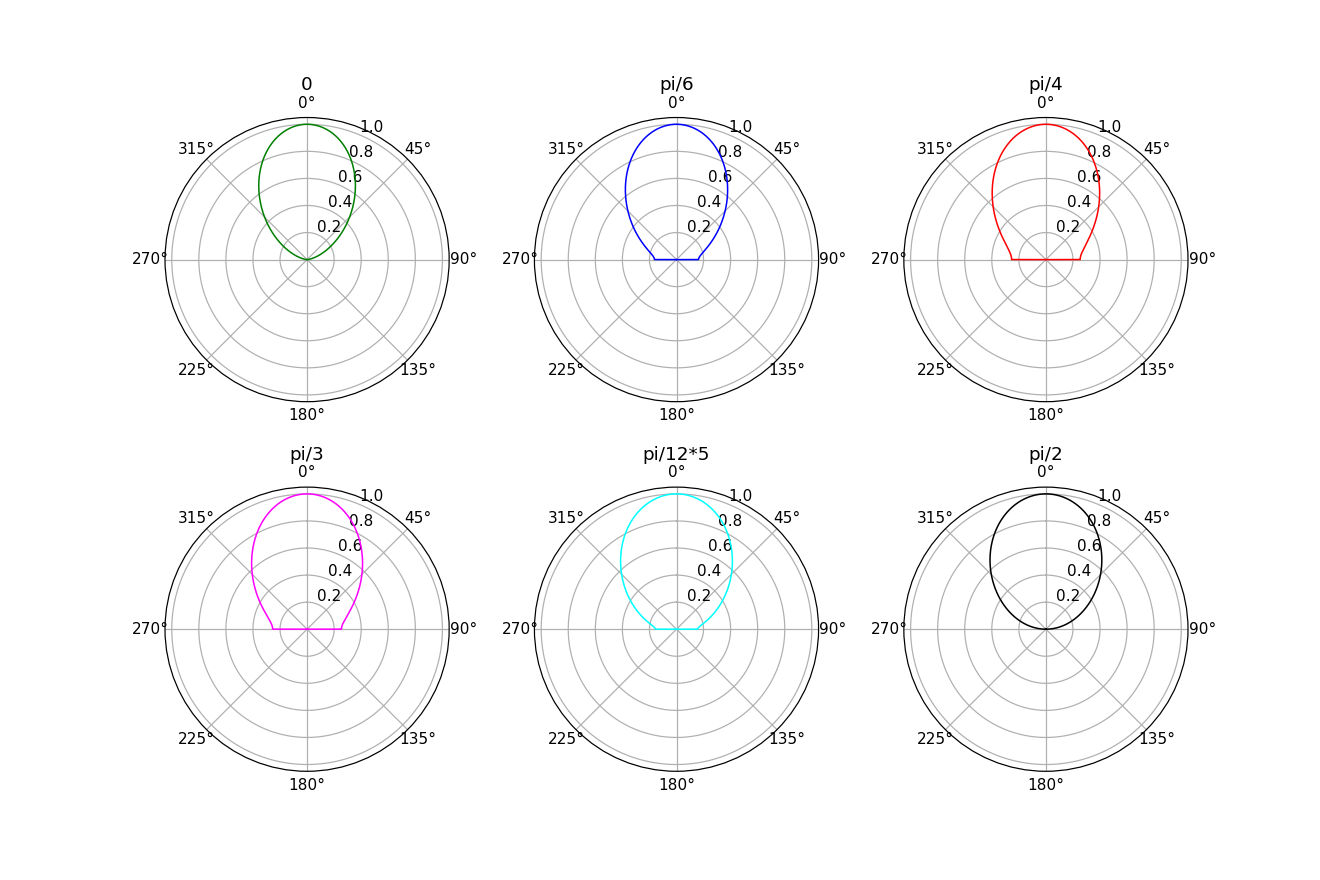

In [35]:
theta = np.linspace(-pi, pi, num=1000)

def log_rp(theta, phi, rp): 
    value = w2db(rp(theta, phi)) + 40
    if (value < 0):
        return 0
    else:
        return value


r1 = [patch_rp_(t, 0.0)  for t in theta]
r2 = [patch_rp_(t, pi/6) for t in theta]
r3 = [patch_rp_(t, pi/4) for t in theta]
r4 = [patch_rp_(t, pi/3) for t in theta]
r5 = [patch_rp_(t, pi/12*5) for t in theta]
r6 = [patch_rp_(t, pi/2) for t in theta]

# r1 = ch.patch_rp(azimuth=theta, tilt=0.001, wavelen=wave_length, width=wave_length/2, length=wave_length/2)
# r2 = ch.patch_rp(azimuth=theta, tilt=pi/12, wavelen=wave_length, width=wave_length/2, length=wave_length/2)
# r3 = ch.patch_rp(azimuth=theta, tilt=pi/6,  wavelen=wave_length, width=wave_length/2, length=wave_length/2)
# r4 = ch.patch_rp(azimuth=theta, tilt=pi/4,  wavelen=wave_length, width=wave_length/2, length=wave_length/2)
# r5 = ch.patch_rp(azimuth=theta, tilt=pi/3,  wavelen=wave_length, width=wave_length/2, length=wave_length/2)
# r6 = ch.patch_rp(azimuth=theta, tilt=pi/2,  wavelen=wave_length, width=wave_length/2, length=wave_length/2)

figure(100, figsize=(12,8))
ax1 = subplot2grid((2,3), (0,0), projection='polar')
ax2 = subplot2grid((2,3), (0,1), projection='polar')
ax3 = subplot2grid((2,3), (0,2), projection='polar')
ax4 = subplot2grid((2,3), (1,0), projection='polar')
ax5 = subplot2grid((2,3), (1,1), projection='polar')
ax6 = subplot2grid((2,3), (1,2), projection='polar')

ax1.plot(theta, r1, color='green',   linewidth=1)
ax2.plot(theta, r2, color='blue',    linewidth=1)
ax3.plot(theta, r3, color='red',     linewidth=1)
ax4.plot(theta, r4, color='magenta', linewidth=1)
ax5.plot(theta, r5, color='cyan',    linewidth=1)
ax6.plot(theta, r6, color='black',   linewidth=1)

ax1.set_theta_zero_location('N')
ax2.set_theta_zero_location('N')
ax3.set_theta_zero_location('N')
ax4.set_theta_zero_location('N')
ax5.set_theta_zero_location('N')
ax6.set_theta_zero_location('N')

ax1.set_title("0", va='bottom')
ax2.set_title("pi/6", va='bottom')
ax3.set_title("pi/4", va='bottom')
ax4.set_title("pi/3", va='bottom')
ax5.set_title("pi/12*5", va='bottom')
ax6.set_title("pi/2", va='bottom')

ax1.set_theta_direction(-1)
ax2.set_theta_direction(-1)
ax3.set_theta_direction(-1)
ax4.set_theta_direction(-1)
ax5.set_theta_direction(-1)
ax6.set_theta_direction(-1)

plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.show()

<IPython.core.display.Javascript object>


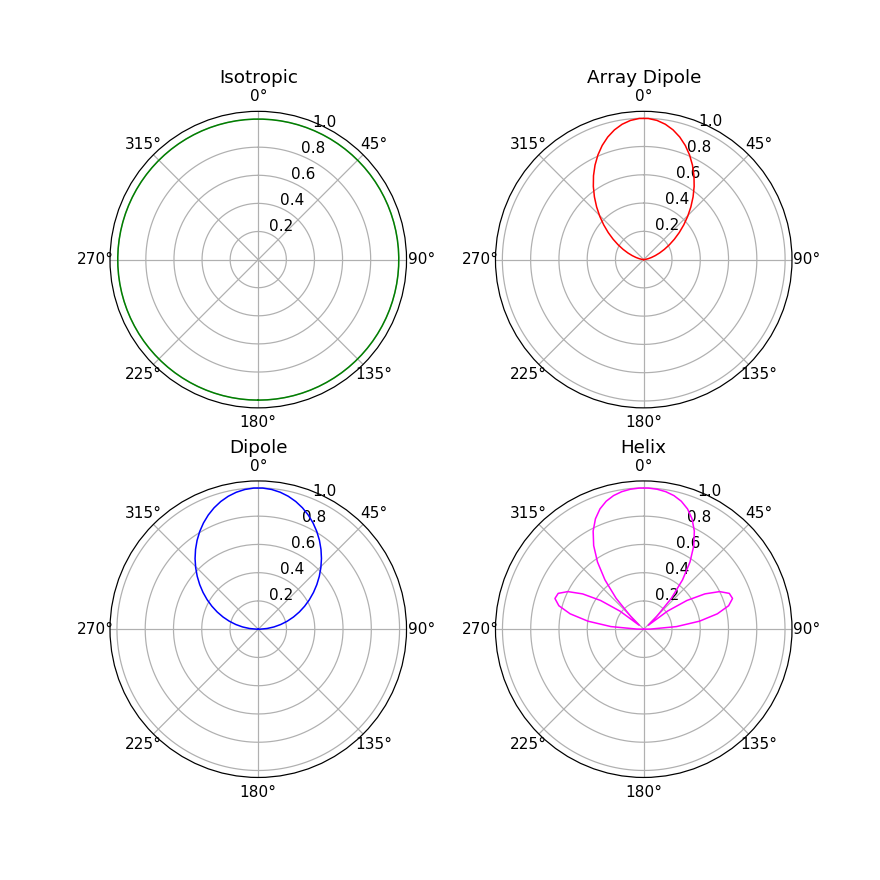

In [36]:
#
# Plotting radiation pattern of different antennas
#
theta = np.linspace(-pi, pi, num=100)
r1 = [ch.isotropic_rp(azimuth=t) for t in theta]
r2 = [ch.dipole_rp(azimuth=t) for t in theta]
r3 = [ch.array_dipole_rp(azimuth=t, n=2) for t in theta]
r4 = [ch.helix_rp(azimuth=t, n=3) for t in theta]

figure(101, figsize=(8,8))
ax1 = subplot2grid((2,2), (0,0), projection='polar')
ax2 = subplot2grid((2,2), (1,0), projection='polar')
ax3 = subplot2grid((2,2), (0,1), projection='polar')
ax4 = subplot2grid((2,2), (1,1), projection='polar')

ax1.plot(theta, r1, color='green', linewidth=1)
ax2.plot(theta, r2, color='blue', linewidth=1)
ax3.plot(theta, r3, color='red', linewidth=1)
ax4.plot(theta, r4, color='magenta', linewidth=1)

ax1.set_theta_zero_location('N')
ax2.set_theta_zero_location('N')
ax3.set_theta_zero_location('N')
ax4.set_theta_zero_location('N')

ax1.set_title("Isotropic", va='bottom')
ax2.set_title("Dipole", va='bottom')
ax3.set_title("Array Dipole", va='bottom')
ax4.set_title("Helix", va='bottom')

ax1.set_theta_direction(-1)
ax2.set_theta_direction(-1)
ax3.set_theta_direction(-1)
ax4.set_theta_direction(-1)

plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.show()

# ax.set_rscale('log')
# ax.set_rmax(0.008)
# ax.grid(True)